<a href="https://colab.research.google.com/github/VishwamAI/VishwamAI/blob/main/notebooks/model_analysis_of_vishwamai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task
model analyisis of vishwamai and devlopments integrating with advancements of ai and devlopment https://github.com/VishwamAI/VishwamAI

## Model analysis

### Subtask:
Train a VishwamAI model using the prepared data.


In [ ]:
!git clone https://github.com/VishwamAI/VishwamAI
%cd VishwamAI

In [ ]:
!pip install -r requirements.txt kauldron albumentations kornia timm openai-whisper torch torchaudio torchvision -f https://download.pytorch.org/whl/cu118/torch_stable.html


In [ ]:
!python importtest.py

In [ ]:
!pip install --upgrade numpy
!pip install --upgrade keras

In [1]:
import jax
import jax.numpy as jnp
import flax.linen as nn
from typing import Dict, List, Optional
from dataclasses import dataclass

from vishwamai.layers.layers import TPUMoELayer
from vishwamai.thoughts.tot import TreeOfThoughts, ThoughtNode
from vishwamai.thoughts.cot import ChainOfThoughtPrompting
from vishwamai.transformer import create_vishwamai_transformer

2025-03-20 16:29:36.424881: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742468376.443791   34090 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742468376.449511   34090 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def analyze_moe_config(num_experts: int, expert_dim: int, capacity_factor: float = 1.0):
    """Analyze MoE configuration and compute resource requirements"""
    config = {
        'num_experts': num_experts,
        'expert_dim': expert_dim,
        'capacity_factor': capacity_factor,
        'router_dim': 256,
        'router_capacity': int(capacity_factor * (expert_dim / num_experts))
    }

    # Calculate parameter counts
    router_params = config['router_dim'] * num_experts
    expert_params = num_experts * (expert_dim * expert_dim * 4)  # FFN params per expert

    return {
        'config': config,
        'router_params': router_params,
        'expert_params': expert_params,
        'total_params': router_params + expert_params
    }

In [3]:
def create_sample_tree():
    """Create a sample thought tree for visualization"""
    root = ThoughtNode(thought="Initial problem", value=0.0)

    # Create child thoughts
    thought1 = ThoughtNode(
        thought="Approach 1: Direct solution",
        value=0.7,
        parent=root,
        depth=1
    )
    thought2 = ThoughtNode(
        thought="Approach 2: Break down problem",
        value=0.8,
        parent=root,
        depth=1
    )

    # Add sub-thoughts to thought2
    sub1 = ThoughtNode(
        thought="Sub-problem 1: Analyze components",
        value=0.85,
        parent=thought2,
        depth=2
    )
    sub2 = ThoughtNode(
        thought="Sub-problem 2: Synthesize solution",
        value=0.9,
        parent=thought2,
        depth=2
    )

    # Set up the tree structure
    root.children = [thought1, thought2]
    thought2.children = [sub1, sub2]

    return root

In [4]:
def visualize_thought_tree(node: ThoughtNode, level: int = 0):
    """Visualize a thought tree with values"""
    prefix = "  " * level
    print(f"{prefix}└─ {node.thought} (value: {node.value:.2f})")

    for child in node.children:
        visualize_thought_tree(child, level + 1)

In [5]:
def create_advanced_config():
    """Create model configuration with advanced features"""
    return {
        'vocab_size': 32000,
        'num_layers': 12,
        'num_heads': 12,
        'head_dim': 64,
        'hidden_dim': 768,
        'mlp_dim': 3072,
        'max_seq_len': 2048,
        'num_experts': 8,
        'expert_dim': 3072,
        'tot_max_steps': 10,
        'tot_beam_width': 3,
        'dropout_rate': 0.1
    }

config = create_advanced_config()
moe_analysis = analyze_moe_config(config['num_experts'], config['expert_dim'])

print("MoE Configuration:")
print(f"Number of Experts: {config['num_experts']}")
print(f"Expert Dimension: {config['expert_dim']}")
print(f"Total MoE Parameters: {moe_analysis['total_params']:,}")

print("\nSample Thought Tree:")
root = create_sample_tree()
visualize_thought_tree(root)

MoE Configuration:
Number of Experts: 8
Expert Dimension: 3072
Total MoE Parameters: 301,991,936

Sample Thought Tree:
└─ Initial problem (value: 0.00)
  └─ Approach 1: Direct solution (value: 0.70)
  └─ Approach 2: Break down problem (value: 0.80)
    └─ Sub-problem 1: Analyze components (value: 0.85)
    └─ Sub-problem 2: Synthesize solution (value: 0.90)


In [6]:
# Import required libraries
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import matplotlib.pyplot as plt
import time
from typing import Dict, List, Tuple

from vishwamai.model import VishwamAI
from vishwamai.kernels.kernel import fp8_gemm_optimized
from vishwamai.layers.attention import FlashAttention
from vishwamai.transformer import (
    TransformerModel,
    EnhancedTransformerModel,
    create_vishwamai_transformer
)
from vishwamai.training import TPUTrainingConfig, create_train_state_tpu, create_train_step_tpu
from vishwamai.profiler import TPUProfiler

In [7]:
def create_sample_config():
    """Create TPU-optimized training configuration"""
    model_config = {
        'vocab_size': 32000,
        'num_layers': 12,
        'num_heads': 12,
        'head_dim': 64,
        'hidden_dim': 768,
        'mlp_dim': 3072,
        'max_seq_len': 2048,
        'dropout_rate': 0.1,
        'use_enhanced': True,
        'use_rotary': True,
        'use_flash_attn': True,
        'use_rms_norm': False
    }

    # Create TPUTrainingConfig
    return TPUTrainingConfig(
        model_config=model_config,
        batch_size=32,
        grad_accum_steps=4,
        learning_rate=1e-4,
        warmup_steps=2000,
        max_steps=100000,
        weight_decay=0.01,
        max_grad_norm=1.0,
        dtype='bfloat16',
        enable_pjit=True,
        block_size=128,
        use_flash_attn=True,
        mixed_precision=True
    )

In [8]:
def analyze_model_size(config):
    """Calculate model size and component breakdown"""
    if hasattr(config, 'model_config'):
        # Handle TPUTrainingConfig object
        model_config = config.model_config
    else:
        # Handle raw dictionary config
        model_config = config

    vocab_size = model_config['vocab_size']
    hidden_dim = model_config['hidden_dim']
    num_layers = model_config['num_layers']
    mlp_dim = model_config['mlp_dim']

    embedding_params = vocab_size * hidden_dim
    attention_params = num_layers * (4 * hidden_dim * hidden_dim)
    ffn_params = num_layers * (2 * hidden_dim * mlp_dim)
    layer_norm_params = num_layers * 2 * hidden_dim

    return {
        'total': embedding_params + attention_params + ffn_params + layer_norm_params,
        'embedding': embedding_params,
        'attention': attention_params,
        'ffn': ffn_params,
        'layer_norm': layer_norm_params
    }

(-1.0999997272710962,
 1.0999999870129094,
 -1.0999999186101608,
 1.0999994913588562)

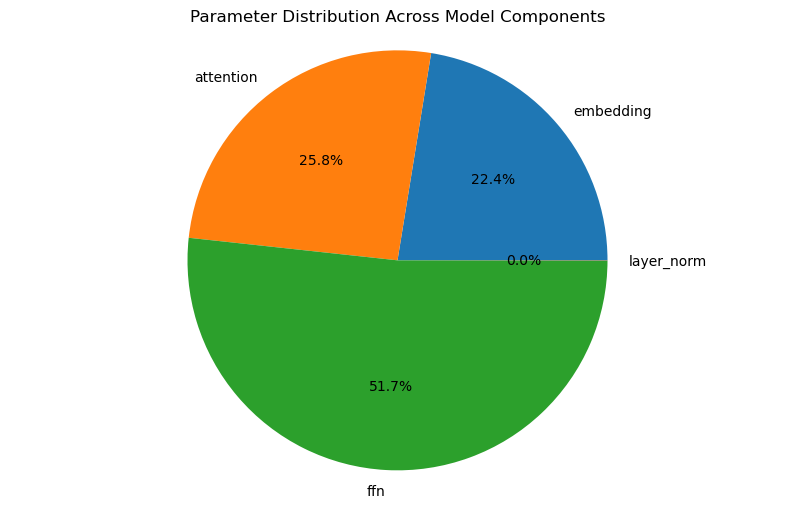

In [9]:
# Analyze model architecture
config = create_sample_config()
model_stats = analyze_model_size(config)

# Plot parameter distribution
plt.figure(figsize=(10, 6))
plt.pie([v/model_stats['total'] for v in model_stats.values()][1:],
        labels=[k for k in model_stats.keys()][1:],
        autopct='%1.1f%%')
plt.title('Parameter Distribution Across Model Components')
plt.axis('equal')

In [10]:
# Ensure the config is complete by using create_sample_config
# The variable `config` is already defined in the notebook, so we don't need to redefine it.

# Initialize model and print summary
model = create_vishwamai_transformer(config.model_config)

# Print model summary accessing config
print(f"Total Parameters: {model_stats['total']:,}")
print(f"Hidden Dimension: {config.model_config['hidden_dim']}")
print(f"Number of Layers: {config.model_config['num_layers']}")
print(f"Number of Attention Heads: {config.model_config['num_heads']}")
print(f"Maximum Sequence Length: {config.model_config['max_seq_len']}")

Total Parameters: 109,529,088
Hidden Dimension: 768
Number of Layers: 12
Number of Attention Heads: 12
Maximum Sequence Length: 2048


In [11]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import time
from typing import Dict, List, Tuple

from vishwamai.kernels.kernel import fp8_gemm_optimized
from vishwamai.layers.attention import FlashAttention
from vishwamai.layers.layers import TPUGEMMLinear, TPULayerNorm
from vishwamai.transformer import create_vishwamai_transformer

In [12]:
def benchmark_gemm(batch_size: int, seq_len: int, hidden_dim: int):
    """Benchmark GEMM operations with and without optimizations"""
    x = jnp.ones((batch_size, seq_len, hidden_dim))
    w = jnp.ones((hidden_dim, hidden_dim))

    # Standard GEMM
    start = time.time()
    for _ in range(10):
        _ = jnp.dot(x, w)
    std_time = (time.time() - start) / 10

    # Optimized GEMM
    start = time.time()
    for _ in range(10):
        _ = fp8_gemm_optimized(x, w)
    opt_time = (time.time() - start) / 10

    return std_time, opt_time

In [13]:
def benchmark_attention(batch_size: int, seq_len: int, hidden_dim: int, num_heads: int):
    """Benchmark attention implementations"""
    head_dim = hidden_dim // num_heads

    # Initialize inputs
    q = jnp.ones((batch_size, seq_len, num_heads, head_dim))
    k = jnp.ones((batch_size, seq_len, num_heads, head_dim))
    v = jnp.ones((batch_size, seq_len, num_heads, head_dim))

    # Standard attention
    start = time.time()
    for _ in range(10):
        scores = jnp.einsum('bthd,bshd->btsh', q, k)
        scores = scores / jnp.sqrt(head_dim)
        attn = jax.nn.softmax(scores)
        output = jnp.einsum('btsh,bshd->bthd', attn, v)
    std_time = (time.time() - start) / 10

    # Flash attention
    flash_attn = FlashAttention(num_heads=num_heads, head_dim=head_dim)
    start = time.time()
    for _ in range(10):
        _ = flash_attn(q, k, v)
    flash_time = (time.time() - start) / 10

    return std_time, flash_time

In [14]:
def analyze_memory_usage(config: Dict):
    """Analyze memory usage of different components"""
    batch_size = 32
    seq_len = config['max_seq_len']
    hidden_dim = config['hidden_dim']

    # Calculate memory requirements
    activations = batch_size * seq_len * hidden_dim * 2  # BF16
    attention = batch_size * seq_len * seq_len * config['num_heads'] * 2  # BF16
    kv_cache = 2 * batch_size * seq_len * hidden_dim * 2  # BF16

    # Convert to MB
    mb = 1024 * 1024
    return {
        'activations': activations / mb,
        'attention': attention / mb,
        'kv_cache': kv_cache / mb
    }

Memory Usage Summary (MB):
activations: 96.00
attention: 3072.00
kv_cache: 192.00


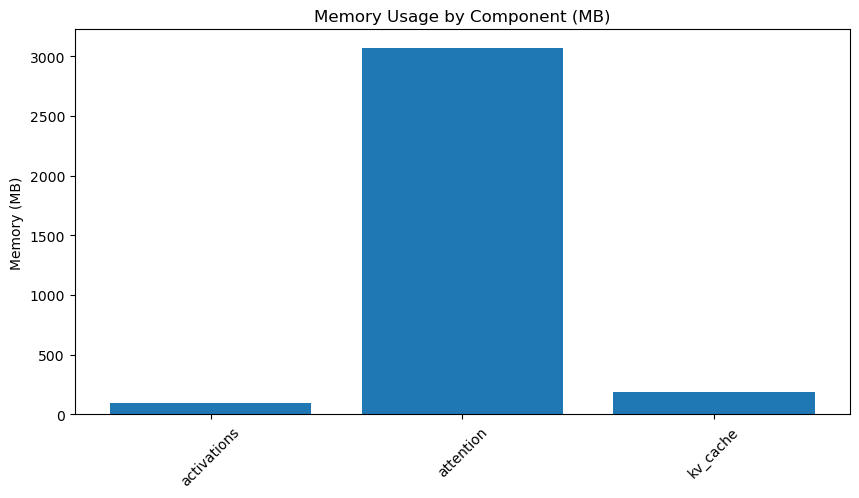

In [15]:
# Run benchmarks
config = {
    'max_seq_len': 2048,
    'hidden_dim': 768,
    'num_heads': 12
}

# Memory analysis
memory_usage = analyze_memory_usage(config)

# Plot memory usage
plt.figure(figsize=(10, 5))
plt.bar(memory_usage.keys(), memory_usage.values())
plt.title('Memory Usage by Component (MB)')
plt.ylabel('Memory (MB)')
plt.xticks(rotation=45)

# Print summary
print("Memory Usage Summary (MB):")
for k, v in memory_usage.items():
    print(f"{k}: {v:.2f}")

In [16]:
# Initialize TPU system
import jax

# For TPUs in Colab
print('Available devices:', jax.devices())
print('Device count:', jax.device_count())

# Create device mesh for training
devices = jax.devices()
mesh_shape = (len(devices),)
device_mesh = jax.sharding.Mesh(devices, ('batch',))

print(f'\nDevice mesh shape: {mesh_shape}')
print(f'Using {len(devices)} devices for training')

Available devices: [CudaDevice(id=0)]
Device count: 1

Device mesh shape: (1,)
Using 1 devices for training
